## Import pakietów

In [30]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from scipy.linalg import eigh
from numpy.linalg import norm
from tabulate import tabulate

# Funkcje

In [31]:
def generate_AR1_covariance(p, rho):
    """Generuje macierz kowariancji AR(1) o wymiarze p i współczynniku rho"""
    return np.array([[rho ** abs(i - j) for j in range(p)] for i in range(p)])

def generate_constant_covariance(p):
    """Generuje jednostkową macierz kowariancji"""
    return np.eye(p)

def generate_MA1_covariance(p, rho):
    """Generuje macierz kowariancji MA(1) o wymiarze p i współczynniku rho"""
    cov_matrix = np.eye(p) 
    for i in range(p - 1):
        cov_matrix[i, i + 1] = rho
        cov_matrix[i + 1, i] = rho
    return cov_matrix

def sample_covariance(X):
    """Zwraca próbkową macierz kowariancji"""
    n = X.shape[0]
    mean = np.mean(X, axis=0)
    centered_X = X - mean
    cov_matrix = np.dot(centered_X.T, centered_X) / n
    return cov_matrix

def thresholding_estimator(S, t):
    """Zwraca estymator progowy macierzy kowariancji"""
    return np.where(np.abs(S) > t, S, 0)

def banding_estimator(S, k):
    """Zwraca estymator pasmowy macierzy kowariancji"""
    p = S.shape[0]
    banded_S = np.zeros_like(S)
    for i in range(p):
        for j in range(max(0, i - k), min(p, i + k + 1)):
            banded_S[i, j] = S[i, j]
    return banded_S

def thresholding_cv(X,p,n,s_vals,N):
    """Wybór progu za pomocą walidacji krzyżowej"""
    n1=int(n*(1-1/np.log(n)))
    n2=n-n1
    
    R_s_values=[]
    for s in s_vals:
        total=0
        for _ in range(N):
            indices=np.random.permutation(n)
            X1,X2=X[indices[:n1]], X[indices[n1:]]
            S1=sample_covariance(X1)
            S2=sample_covariance(X2)
            T=thresholding_estimator(S1,s)
            total+=np.linalg.norm(T-S2, 'fro') ** 2
        R_s=total/N
        R_s_values.append((s,R_s))
    optimal_s, min_loss=min(R_s_values, key=lambda x: x[1])
    #print(f"Optimal CV threshold for {p} is {optimal_s}. Loss={min_loss}")
    return optimal_s, min_loss, R_s_values

def thresholding_oracle(X,p,s_vals, matrix):
    """Wybór progu z użyciem prawdziwej macierzy kowariancji"""
    R_s_values=[]
    for s in s_vals:
        T=thresholding_estimator(sample_covariance(X),s)
        R_s=np.linalg.norm(T-matrix,'fro')**2
        R_s_values.append((s,R_s))
    optimal_s, min_loss=min(R_s_values, key=lambda x: x[1])
    #print(f"Optimal oracle threshold for {p} is {optimal_s}. Loss={min_loss}")
    return optimal_s, min_loss, R_s_values

def banding_cv(X,p,n,k_vals,N):
    """Wybór progu za pomocą walidacji krzyżowej"""
    n1=int(n/3)
    n2=n-n1
    
    R_s_values=[]
    for k in k_vals:
        total=0
        for _ in range(N):
            indices=np.random.permutation(n)
            X1,X2=X[indices[:n1]], X[indices[n1:]]
            S1=sample_covariance(X1)
            S2=sample_covariance(X2)
            B=banding_estimator(S1,k)
            total+=np.linalg.norm(B-S2, 1)
        R_s=total/N
        R_s_values.append((k,R_s))
    optimal_k, min_loss=min(R_s_values, key=lambda x: x[1])
    #print(f"Optimal CV band width for {p} is {optimal_k}. Loss={min_loss}")
    return optimal_k, min_loss, R_s_values

def banding_oracle(X,p,k_vals,matrix):
    """Wybór progu z użyciem prawdziwej macierzy kowariancji"""
    R_s_values=[]
    for k in k_vals:
        B=banding_estimator(sample_covariance(X),k)
        R_s=np.linalg.norm(B-matrix,1)
        R_s_values.append((k,R_s))
    optimal_k, min_loss=min(R_s_values, key=lambda x: x[1])
    #print(f"Optimal oracle band width for {p} is {optimal_k}.Loss={min_loss}")
    return optimal_k, min_loss, R_s_values

# Wybór progu i szerokości pasma dla AR(1)

In [32]:
np.random.seed(42)
p_values = [30, 100, 200]
rho = 0.7
n = 100
N = 50
n_replications=100
s_vals = np.linspace(0.01, 1, 100)

for p in p_values:
    k_vals = range(0, p)
    true_cov = generate_AR1_covariance(p, rho)

    s_cv_list,s_o_list,k_cv_list,k_o_list=[],[],[],[]
    R_s_cv_list, R_s_o_list,R_k_cv_list,R_k_o_list=[],[],[],[]

    for _ in range(n_replications):
        
        X = np.random.multivariate_normal(np.zeros(p), true_cov, n)
        
        s_cv, R_s_cv, _ = thresholding_cv(X, p, n, s_vals, N)
        s_o, R_s_o, _ = thresholding_oracle(X, p, s_vals, true_cov)
        k_cv, R_k_cv, _= banding_cv(X, p, n, k_vals, N)
        k_o, R_k_o, _ = banding_oracle(X, p, k_vals, true_cov)

        s_cv_list.append(s_cv)
        s_o_list.append(s_o)
        k_cv_list.append(k_cv)
        k_o_list.append(k_o)
    
        R_s_cv_list.append(R_s_cv)
        R_s_o_list.append(R_s_o)
        R_k_cv_list.append(R_k_cv)
        R_k_o_list.append(R_k_o)

    mean_s_cv=np.mean(s_cv_list)
    sd_s_cv=np.std(s_cv_list) 

    mean_R_s_cv = np.mean(R_s_cv_list)
    sd_R_s_cv = np.std(R_s_cv_list) 

    mean_s_o=np.mean(s_o_list)
    sd_s_o=np.std(s_o_list) 

    mean_R_s_o = np.mean(R_s_o_list)
    sd_R_s_o = np.std(R_s_o_list) 

    mean_k_cv=np.mean(k_cv_list)
    sd_k_cv=np.std(k_cv_list) 

    mean_R_k_cv = np.mean(R_k_cv_list)
    sd_R_k_cv = np.std(R_k_cv_list)

    mean_k_o=np.mean(k_o_list)
    sd_k_o=np.std(k_o_list) 

    mean_R_k_o = np.mean(R_k_o_list)
    sd_R_k_o = np.std(R_k_o_list)

    
    headers = ["Próg CV", "Błąd dla progu CV", "Próg optymalny", "Błąd dla progu optymalnego", 
            "Szerokość pasma CV", "Błąd dla szerokości pasma CV", "Szerokość pasma optymalna", 
            "Błąd dla szerokości pasma optymalnej"]

    data = [
        [f"{mean_s_cv:.2f} ({sd_s_cv:.2f})", f"{mean_R_s_cv:.2f} ({sd_R_s_cv:.2f})", 
        f"{mean_s_o:.2f} ({sd_s_o:.2f})", f"{mean_R_s_o:.2f} ({sd_R_s_o:.2f})", 
        f"{mean_k_cv:.2f} ({sd_k_cv:.2f})", f"{mean_R_k_cv:.2f} ({sd_R_k_cv:.2f})", 
        f"{mean_k_o:.2f} ({sd_k_o:.2f})", f"{mean_R_k_o:.2f} ({sd_R_k_o:.2f})"]
    ]

    print(f'Wyniki dla p={p}')
    print(tabulate(data, headers=headers, tablefmt="grid"))


Wyniki dla p=30
+-------------+---------------------+------------------+------------------------------+----------------------+--------------------------------+-----------------------------+----------------------------------------+
| Próg CV     | Błąd dla progu CV   | Próg optymalny   | Błąd dla progu optymalnego   | Szerokość pasma CV   | Błąd dla szerokości pasma CV   | Szerokość pasma optymalna   | Błąd dla szerokości pasma optymalnej   |
+=============+=====================+==================+==============================+======================+================================+=============================+========================================+
| 0.20 (0.07) | 50.50 (5.22)        | 0.19 (0.04)      | 7.93 (1.65)                  | 4.66 (1.05)          | 5.93 (0.45)                    | 6.30 (1.36)                 | 2.29 (0.40)                            |
+-------------+---------------------+------------------+------------------------------+----------------------+--------------

# Pojedyncza realizacja dla AR(1)

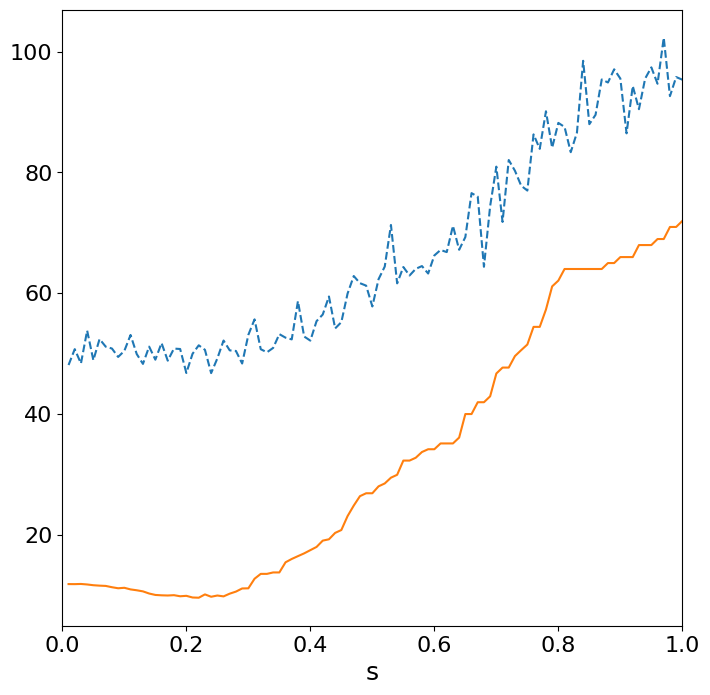

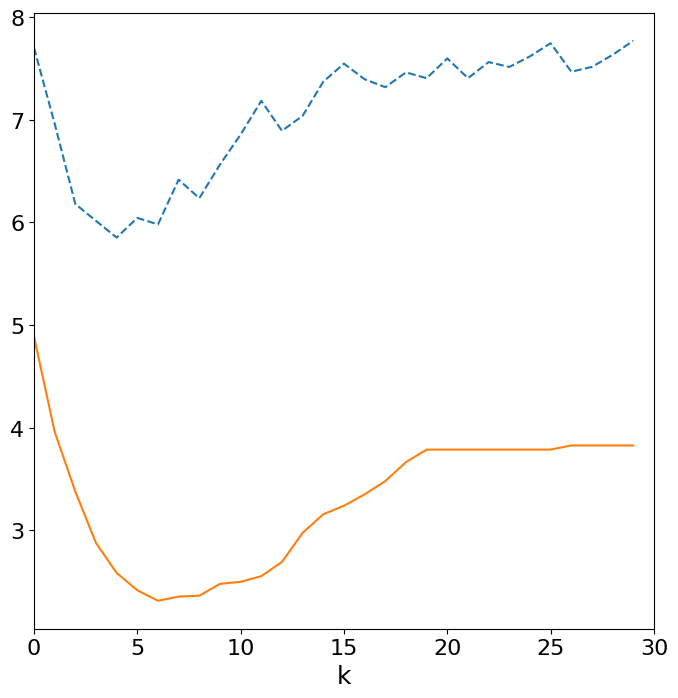

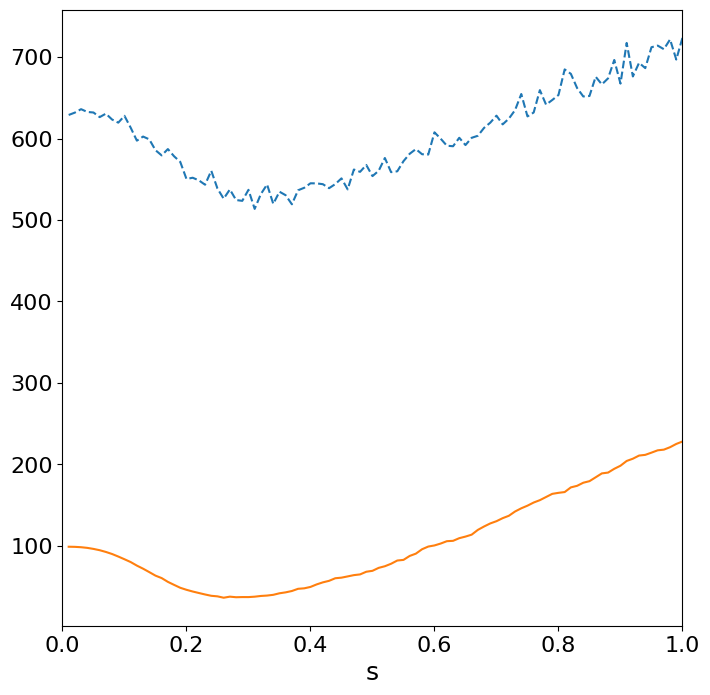

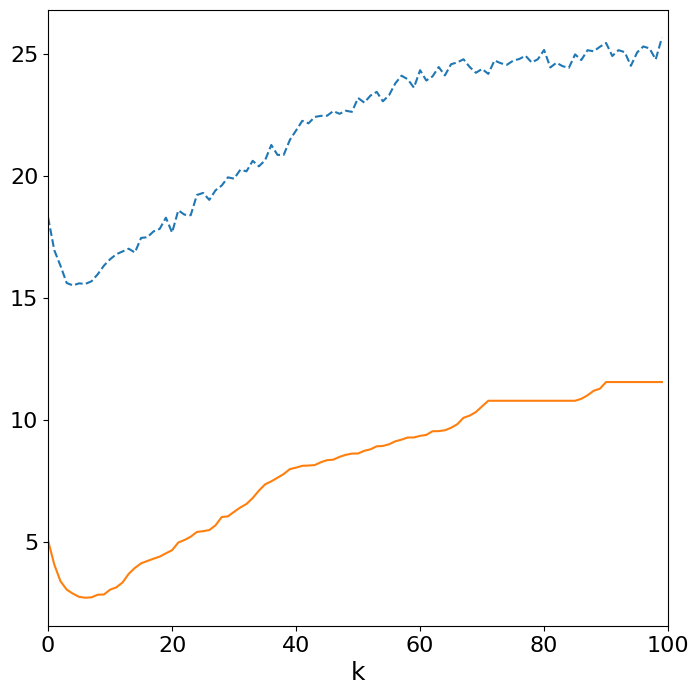

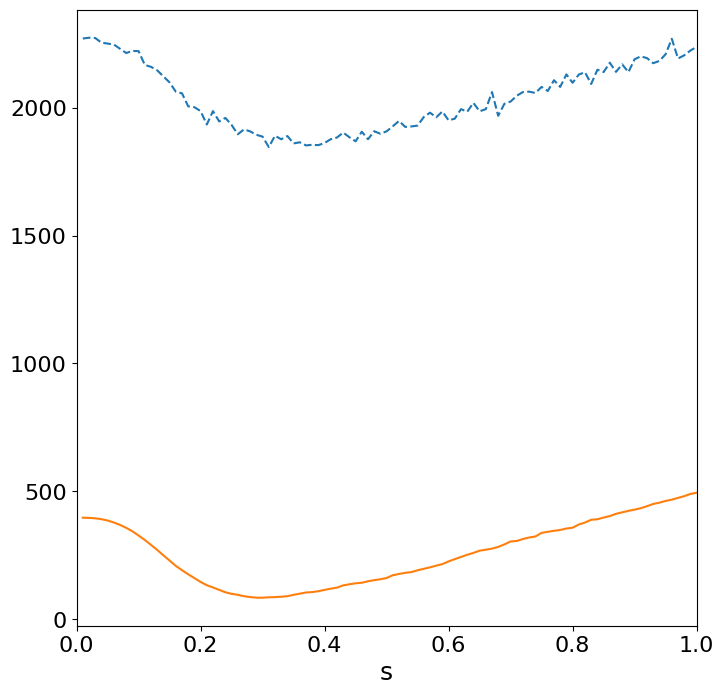

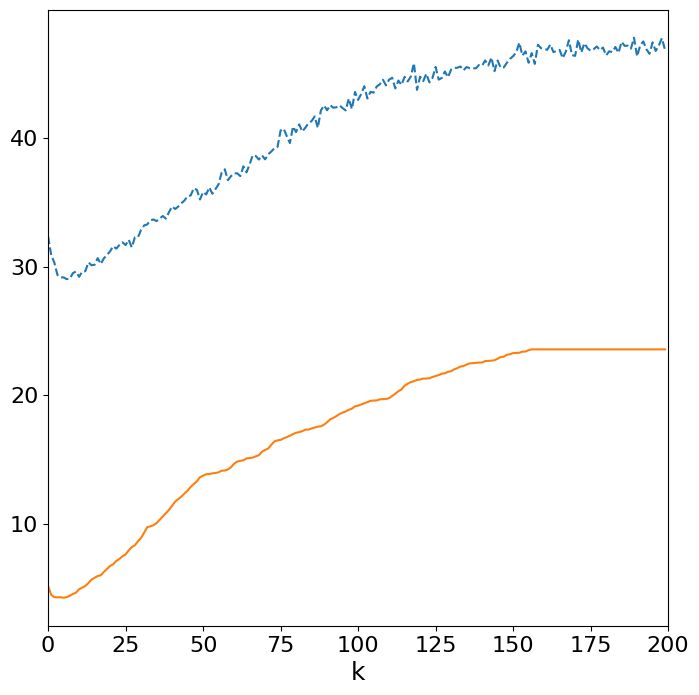

In [33]:
np.random.seed(42)
p_values = [30, 100, 200]
rho = 0.7
n = 100
N = 50
s_vals = np.linspace(0.01, 1, 100)

# Ścieżka do pulpitu
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

for p in p_values:
    k_vals = range(0, p)
    true_cov = generate_AR1_covariance(p, rho)
    X = np.random.multivariate_normal(np.zeros(p), true_cov, n)
    
    t_cv = thresholding_cv(X, p, n, s_vals, N)[2]
    t_o = thresholding_oracle(X, p, s_vals, true_cov)[2]
    b_cv = banding_cv(X, p, n, k_vals, N)[2]
    b_o = banding_oracle(X, p, k_vals, true_cov)[2]
    
    s_vals_cv, R_s_vals_cv = zip(*t_cv)
    s_vals_o, R_s_vals_o = zip(*t_o)
    s_vals_b_cv, R_s_vals_b_cv = zip(*b_cv)
    s_vals_b_o, R_s_vals_b_o = zip(*b_o)

    plt.figure(figsize=(8, 8)) 
    plt.plot(s_vals_cv, R_s_vals_cv, label=r'$\hat{R}(s)$', linestyle='--')
    plt.plot(s_vals_o, R_s_vals_o, label=r'$R_1(s)$', linestyle='-')
    plt.xlabel("s", fontsize=18)
    plt.xlim(0, 1)
    
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # frobenius_filename = os.path.join(desktop_path, f'frobenius_p_{p}.svg')
    # plt.savefig(frobenius_filename, format='svg')
    
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 8))  
    plt.plot(s_vals_b_cv, R_s_vals_b_cv, label=r'$\hat{R}(k)$', linestyle='--')
    plt.plot(s_vals_b_o, R_s_vals_b_o, label=r'$R_1(k)$', linestyle='-')
    plt.xlabel("k", fontsize=18) 
    plt.xlim(0, p)
    
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # first_norm_filename = os.path.join(desktop_path, f'first_norm_p_{p}.svg')
    # plt.savefig(first_norm_filename, format='svg')
    
    plt.show()
    plt.close()

## Wybór progu i szerokości pama dla MA(1)

In [34]:
np.random.seed(42)
p_values = [30, 100, 200]
rho = 0.5
n = 100
N = 50
n_replications=100
s_vals = np.linspace(0.01, 1, 100)

for p in p_values:
    k_vals = range(0, p)
    true_cov = generate_MA1_covariance(p, rho)

    s_cv_list,s_o_list,k_cv_list,k_o_list=[],[],[],[]
    R_s_cv_list, R_s_o_list,R_k_cv_list,R_k_o_list=[],[],[],[]

    for _ in range(n_replications):
        
        X = np.random.multivariate_normal(np.zeros(p), true_cov, n)
        
        s_cv, R_s_cv, _ = thresholding_cv(X, p, n, s_vals, N)
        s_o, R_s_o, _ = thresholding_oracle(X, p, s_vals, true_cov)
        k_cv, R_k_cv, _= banding_cv(X, p, n, k_vals, N)
        k_o, R_k_o, _ = banding_oracle(X, p, k_vals, true_cov)

        s_cv_list.append(s_cv)
        s_o_list.append(s_o)
        k_cv_list.append(k_cv)
        k_o_list.append(k_o)
    
        R_s_cv_list.append(R_s_cv)
        R_s_o_list.append(R_s_o)
        R_k_cv_list.append(R_k_cv)
        R_k_o_list.append(R_k_o)

    mean_s_cv=np.mean(s_cv_list)
    sd_s_cv=np.std(s_cv_list) 

    mean_R_s_cv = np.mean(R_s_cv_list)
    sd_R_s_cv = np.std(R_s_cv_list) 

    mean_s_o=np.mean(s_o_list)
    sd_s_o=np.std(s_o_list) 

    mean_R_s_o = np.mean(R_s_o_list)
    sd_R_s_o = np.std(R_s_o_list) 

    mean_k_cv=np.mean(k_cv_list)
    sd_k_cv=np.std(k_cv_list) 

    mean_R_k_cv = np.mean(R_k_cv_list)
    sd_R_k_cv = np.std(R_k_cv_list)

    mean_k_o=np.mean(k_o_list)
    sd_k_o=np.std(k_o_list) 

    mean_R_k_o = np.mean(R_k_o_list)
    sd_R_k_o = np.std(R_k_o_list)

    headers = ["Próg CV", "Błąd dla progu CV", "Próg optymalny", "Błąd dla progu optymalnego", 
            "Szerokość pasma CV", "Błąd dla szerokości pasma CV", "Szerokość pasma optymalna", 
            "Błąd dla szerokości pasma optymalnej"]

    data = [
        [f"{mean_s_cv:.2f} ({sd_s_cv:.2f})", f"{mean_R_s_cv:.2f} ({sd_R_s_cv:.2f})", 
        f"{mean_s_o:.2f} ({sd_s_o:.2f})", f"{mean_R_s_o:.2f} ({sd_R_s_o:.2f})", 
        f"{mean_k_cv:.2f} ({sd_k_cv:.2f})", f"{mean_R_k_cv:.2f} ({sd_R_k_cv:.2f})", 
        f"{mean_k_o:.2f} ({sd_k_o:.2f})", f"{mean_R_k_o:.2f} ({sd_R_k_o:.2f})"]
    ]

    print(f'Wyniki dla p={p}')
    print(tabulate(data, headers=headers, tablefmt="grid"))


Wyniki dla p=30
+-------------+---------------------+------------------+------------------------------+----------------------+--------------------------------+-----------------------------+----------------------------------------+
| Próg CV     | Błąd dla progu CV   | Próg optymalny   | Błąd dla progu optymalnego   | Szerokość pasma CV   | Błąd dla szerokości pasma CV   | Szerokość pasma optymalna   | Błąd dla szerokości pasma optymalnej   |
+=============+=====================+==================+==============================+======================+================================+=============================+========================================+
| 0.31 (0.03) | 42.77 (2.81)        | 0.29 (0.03)      | 1.61 (0.52)                  | 1.04 (0.20)          | 4.59 (0.24)                    | 1.00 (0.00)                 | 0.67 (0.14)                            |
+-------------+---------------------+------------------+------------------------------+----------------------+--------------

# Pojedyncza realizacja dla MA(1)

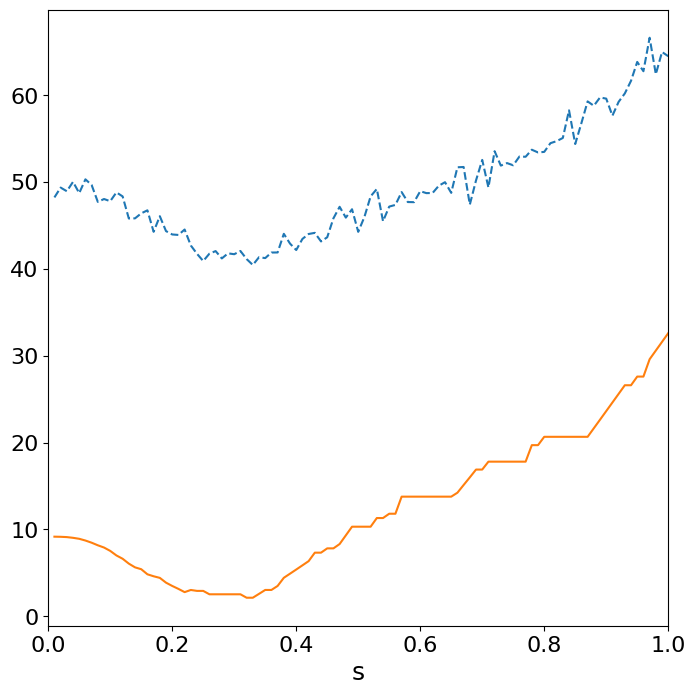

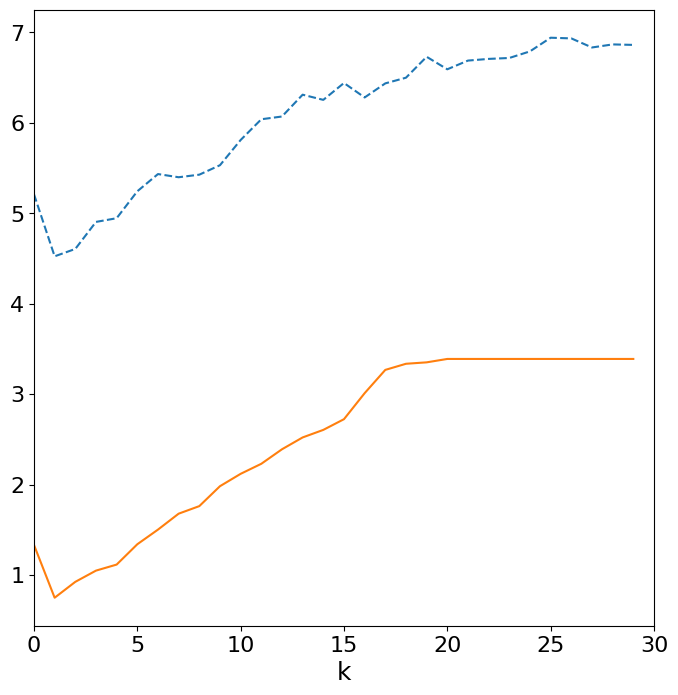

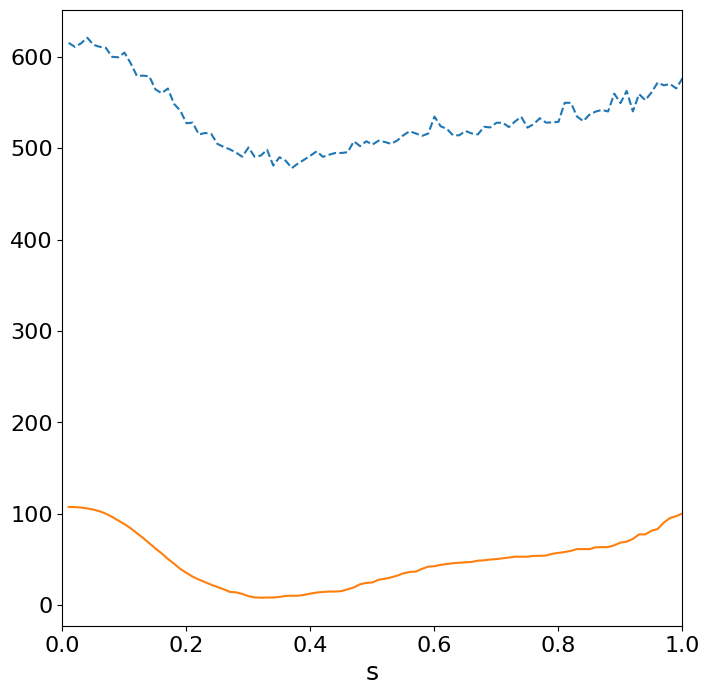

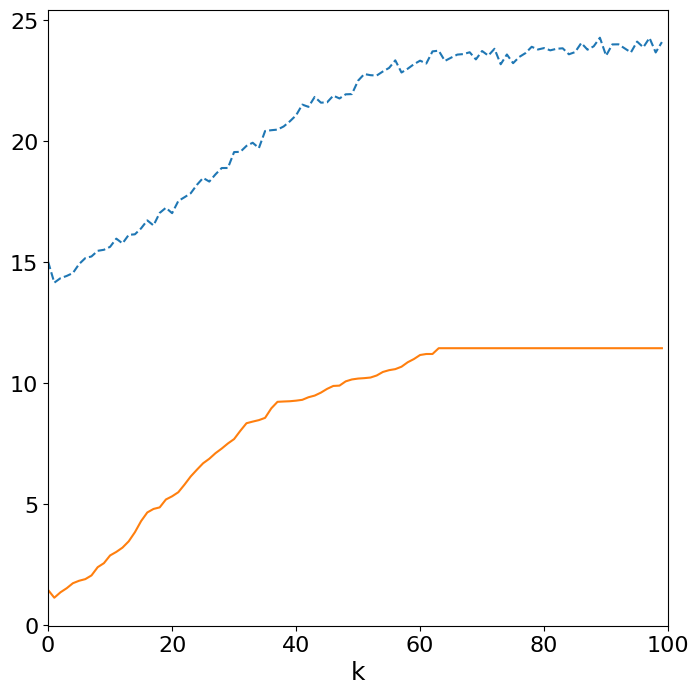

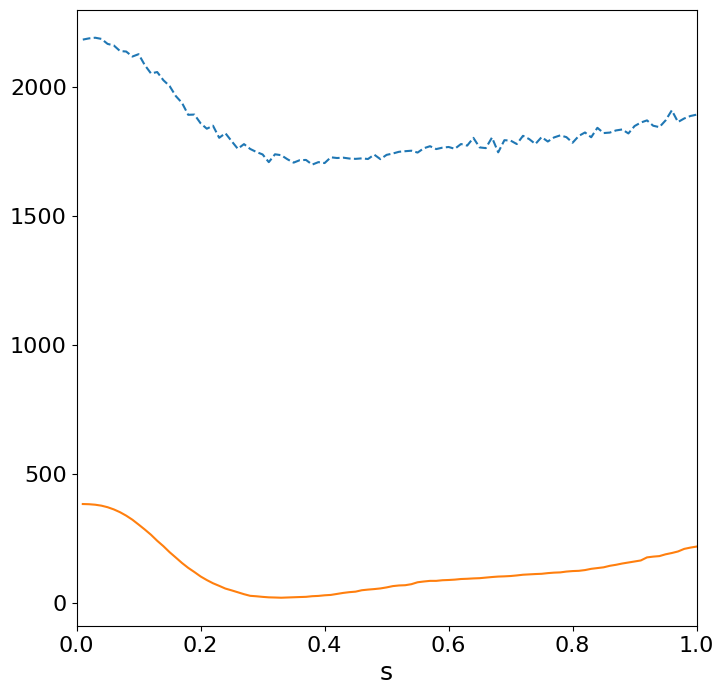

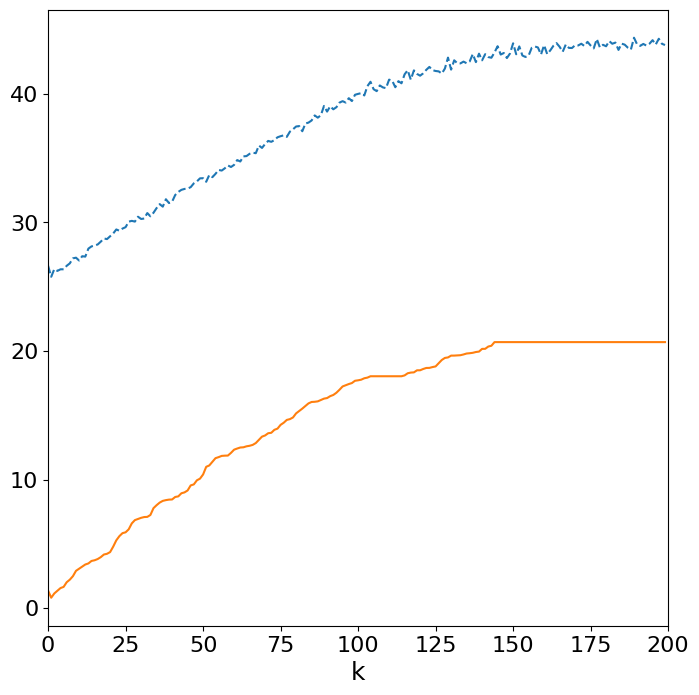

In [35]:
np.random.seed(42)
p_values = [30, 100, 200]
rho = 0.5
n = 100
N = 50
s_vals = np.linspace(0.01, 1, 100)

# Ścieżka do pulpitu
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

for p in p_values:
    k_vals = range(0, p)
    true_cov = generate_MA1_covariance(p, rho)
    X = np.random.multivariate_normal(np.zeros(p), true_cov, n)
    
    t_cv = thresholding_cv(X, p, n, s_vals, N)[2]
    t_o = thresholding_oracle(X, p, s_vals, true_cov)[2]
    b_cv = banding_cv(X, p, n, k_vals, N)[2]
    b_o = banding_oracle(X, p, k_vals, true_cov)[2]
    
    s_vals_cv, R_s_vals_cv = zip(*t_cv)
    s_vals_o, R_s_vals_o = zip(*t_o)
    s_vals_b_cv, R_s_vals_b_cv = zip(*b_cv)
    s_vals_b_o, R_s_vals_b_o = zip(*b_o)

    plt.figure(figsize=(8, 8)) 
    plt.plot(s_vals_cv, R_s_vals_cv, label=r'$\hat{R}(s)$', linestyle='--')
    plt.plot(s_vals_o, R_s_vals_o, label=r'$R_1(s)$', linestyle='-')
    plt.xlabel("s", fontsize=18)  
    plt.xlim(0, 1)
    
    plt.tick_params(axis='both', which='major', labelsize=16)

    # frobenius_filename = os.path.join(desktop_path, f'frobenius_p_{p}_ma.svg')
    # plt.savefig(frobenius_filename, format='svg')
    
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 8))
    plt.plot(s_vals_b_cv, R_s_vals_b_cv, label=r'$\hat{R}(k)$', linestyle='--')
    plt.plot(s_vals_b_o, R_s_vals_b_o, label=r'$R_1(k)$', linestyle='-')
    plt.xlabel("k", fontsize=18)
    plt.xlim(0, p)

    plt.tick_params(axis='both', which='major', labelsize=16)

    # first_norm_filename = os.path.join(desktop_path, f'first_norm_p_{p}_ma.svg')
    # plt.savefig(first_norm_filename, format='svg')
    
    plt.show()
    plt.close()